In [1]:
import numpy as np
from NonlinearController.mpc_utils import *
# from NonlinearController.controllers import *
from NonlinearController.model_utils import *
from NonlinearController.lpv_embedding import *
from NonlinearController.systems import FullUnbalancedDisc
from NonlinearController.models import *
import matplotlib.pyplot as plt
import qpsolvers as qp
from NonlinearController.utils import *
import random

In [26]:
def randomLevelReferenceSteps(Nsim, nt_range, level_range):
    x_reference_list = np.array([])
    Nsim_remaining = Nsim
    current_amp = 0
    while True:
        Nsim_steps = random.randint(nt_range[0],nt_range[1])
        Nsim_remaining = Nsim_remaining - Nsim_steps
        current_amp += random.uniform(level_range[0],level_range[1])

        x_reference_list = np.hstack((x_reference_list, np.ones(Nsim_steps)*current_amp))

        if Nsim_remaining <= 0:
            x_reference_list = x_reference_list[:Nsim]
            break
    return x_reference_list

In [212]:
##################  System  #######################
dt = 0.1
system = FullUnbalancedDisc(dt=dt, sigma_n=[0.0])
system.reset_state()

##################  MPC variable specification  #######################
Nc=10; nr_iterations = 10; nr_sim_steps = 30

w_max = 12; w_min = -w_max
q_min = [-100]; q_max = [100] # augmented with the velocity states
w0 = 0; q0 = [0.0]#q0 = [np.sin(0), np.cos(0)]# q0 = np.array([[1,2]]).T

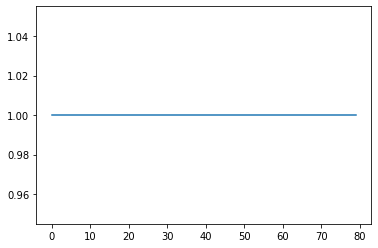

In [213]:
a = 1.; reference_theta = np.hstack((np.ones(10)*a,np.ones(10)*a,np.ones(60)*a))
# reference_theta = np.sin(np.arange(0,nr_sim_steps+Nc)/np.pi*1.5)*2
# reference_theta = randomLevelReference(nr_sim_steps+Nc, [10,15], [-3.1,3.1])
# reference = np.vstack((np.sin(reference_theta),np.cos(reference_theta)))
# reference_theta = randomLevelReferenceSteps(nr_sim_steps+Nc,[10,12],[-3.1,3.1])
reference = reference_theta[np.newaxis]
plt.plot(reference[0,:])

In [214]:
class normalizer():
    def __init__(self, y0, ystd, u0, ustd):
        self.y0 = y0
        self.ystd = ystd

        self.u0 = u0
        self.ustd = ustd

In [215]:
##################  Offline Computation  #######################
# Temporary hardcoded variables
nx = 2
nu = 1
ny = 1
nz = nx+ny
ne = 1

# initialize objective function matrices
# Q1 = np.eye(ny)*500
Q1 = np.zeros((ny,ny)); np.fill_diagonal(Q1, [2000])
Q2 = np.zeros((nz,nz)); Q2[ny:,ny:] = np.eye(nx)
Omega1 = get_Omega(Nc, Q1)
Omega2 = get_Omega(Nc, Q2)

R = np.eye(nu)*1;# Q = np.zeros((nz,nz)); np.fill_diagonal(Q, [200.,200.,1.,1.]) #Q = np.matrix('10,0,0;0,10,0;0,0,10')# these are user defined
Psi = get_Psi(Nc, R)
# Omega = get_Omega(Nc, Q)

# extended objective matrices for soft constraints
e_lambda = 1e8 # weighting of minimizing e in objective function
Ge = np.zeros((Nc*nu+ne,Nc*nu+ne)) 
Ge[-ne:,-ne:] = e_lambda

embedder = CasADi_velocity_lpv_embedder(Nc=Nc, n_stages=20, numerical_method=1)

# normalize initial input and output
norm = normalizer(np.array([0.0]), np.array([1.0]), 0, 1)#model.norm
u0 = norm_input(w0, norm)
y0 = norm_output(q0, norm)

# determine constraint matrices
u_min = norm_input(w_min, norm); u_max = norm_input(w_max, norm)
y_min = np.hstack((norm_output(q_min, norm), np.ones(nx)*-1000)); y_max = np.hstack((norm_output(q_max, norm), np.ones(nx)*1000)) # augmented with the velocity states
D, E, M, c = getDEMc(y_min, y_max, u_min, u_max, Nc, nz, nu)
Lambda = np.tril(np.ones((Nc,Nc)),0)

# initialize observer history input and output
# nb = model.nb
# uhist = torch.from_numpy(np.tile(u0,nb+1)).T
# uhist = torch.ones((1,nb))*u0
# na = model.na
# yhist = torch.from_numpy(np.tile(y0,na+1)).T
# yhist = torch.ones((1,na+1))*y0

# initial predicted states, input, and output
X_1 = np.tile(np.zeros((1,2)),Nc+2).T # This cannot be assumed always. Depends on initial conditions of system
U_1 = np.ones((Nc+1)*nu)[np.newaxis].T*u0
Y_1 = np.tile(y0[np.newaxis],Nc).T

##################  Logging  #######################
log_q = np.zeros((ny,nr_sim_steps))
log_w = np.zeros((nu,nr_sim_steps))
log_e = np.zeros((ne,nr_sim_steps))
log_iterations = np.zeros((1,nr_sim_steps))
log_comp_t = np.zeros((4, nr_sim_steps*nr_iterations))

offset = 0
e = 0 #initial value for soft bounds for hotstart

c:\Users\20182739\AppData\Local\Programs\Python\Python39\lib\site-packages\qpsolvers\solvers\typing.py:48: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warn(
c:\Users\20182739\AppData\Local\Programs\Python\Python39\lib\site-packages\qpsolvers\solvers\typing.py:48: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warn(


Sim step: 0, iterations: 1
Sim step: 0, iterations: 2
Sim step: 0, iterations: 3
Sim step: 0, iterations: 4
Sim step: 0, iterations: 5
Sim step: 0, iterations: 6


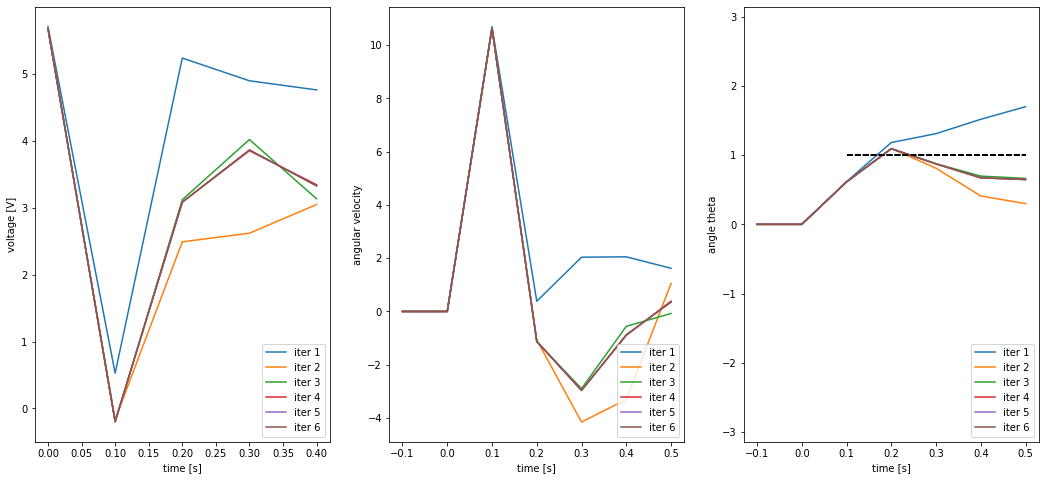

In [216]:
fig_log = plt.figure(figsize=[18, 8])

##################  Online Computation  #######################

#++++++++++++++++++ start simulation step +++++++++++++++++++++++
for k in range(nr_sim_steps):
    # extend normalized reference to form of extended state
    # r = extendReference((reference[:,k:k+Nc] - norm.y0[np.newaxis].T)/norm.ystd[np.newaxis].T, nx, ny, Nc) 
    # r = extendReference(reference[:,k:k+Nc], nx, ny, Nc)
    # r = extendReference(reference[:,k:k+Nc], 0, ny, Nc)
    # r = np.tile(reference[:,k:k+1].T,Nc).T
    r = reference[0,k]*np.ones((Nc,1))
    
    #++++++++++++++++++ start iteration +++++++++++++++++++++++
    for iteration in range(nr_iterations):
        # determine predicted velocity states and output
        dX0 = differenceVector(X_1[:-nx], nx)
        dU0 = differenceVector(U_1, nu)
        # determine extended state from predicted output and velocity states
        Z0 = extendState(Y_1, dX0, nx, ny, Nc)

        # determine lpv state space dependencies
        list_A, list_B, list_C = embedder(X_1, U_1)
        list_ext_A, list_ext_B, list_ext_C = extendABC(list_A, list_B, list_C, nx, ny, nu, Nc)

        # describe optimization problem
        Z = getZ(list_ext_C,Nc,ny,nz)
        Phi = get_Phi(list_ext_A, Nc, nz)
        Gamma = get_Gamma(list_ext_A, list_ext_B, Nc, nz, nu)
        G = 2*(Gamma.T @ (Z.T @ Omega1 @ Z + Omega2) @ Gamma)
        F = 2*(Gamma.T @ (Z.T @ Omega1 @ (Z @ Phi @ Z0[:nz] - r) + Omega2 @ Phi @ Z0[:nz]))
        # G = 2*(Psi + Gamma.T @ Omega @ Gamma)
        # F = 2*(Gamma.T @ Omega @ (Phi @ Z0[:nz] - r))
        # describe constraints
        L = (M @ Gamma + E @ Lambda)
        alpha = np.ones((Nc,1))*U_1[0,0]
        W = -(E @ alpha + (D + M @ Phi) @ Z0[:nz])
        # add soft constraints
        Ge[:Nc*nu, :Nc*nu] = G
        Fe = np.vstack((F, np.zeros((ne,1))))
        Le = np.hstack((L, -np.ones((Nc*2*(nz+nu)+2*nz,ne))))

        # Sy = np.hstack((np.zeros((Nc-1)*ny),np.ones(ny)))[np.newaxis]
        # A = Sy @ Z @ Gamma
        # b = r[-ny,:] - Sy @ Z @ Phi @ Z0[:nz]

        c_terminal = np.vstack((r[-ny:,:],np.zeros((nx,1))))
        M_terminal = np.zeros((nx+ny,ny)); M_terminal[:ny,:] = np.eye(ny)
        E_terminal = np.zeros((nx+ny,nx)); E_terminal[ny:,:] = np.eye(nx)
        Sy = np.hstack((np.zeros((ny,(Nc-1)*ny)),np.eye(ny)))
        # Sz = np.hstack((np.zeros((nz,(Nc-1)*nz)),np.diag(np.hstack((np.zeros(ny),np.ones(nx))))))
        Sx = np.hstack((np.zeros((nx,(Nc-1)*nz+ny)),np.eye(nx)))

        A = (M_terminal @ Sy @ Z + E_terminal @ Sx) @ Gamma
        Ae = np.hstack((A,np.zeros((nz,1))))
        b = c_terminal-(M_terminal @ Sy @ Z + E_terminal @ Sx) @ Phi @ Z0[:nz]

        # solve for optimal U over prediction horizon
        # opt_result = qp.solve_qp(Ge,Fe,Le,c+W,solver="osqp",initvals=np.hstack((dU0[:,0],0)), verbose=False)
        # opt_result = qp.solve_qp(Ge,Fe,Le,c+W,solver="osqp")
        opt_result = qp.solve_qp(P=G,q=F,A=A,b=b,solver="osqp",initvals=np.hstack((dU0[:,0])))
        # opt_result = qp.solve_qp(P=G,q=F,solver="osqp",initvals=np.hstack((dU0[:,0])))
        # split optimization result in optimal input and soft bound variable e
        dU0[:,0] = opt_result[:Nc*nu]
        # e = opt_result[-ne]

        # save previous iteration of U_1
        U_1_old = np.copy(U_1)
        # compute U_1 from dU0 and previous data
        for i in range(1,Nc+1):
            U_1[(i*nu):(i*nu+nu),:] = dU0[((i-1)*nu):((i-1)*nu+nu),:].copy() + U_1[((i-1)*nu):((i-1)*nu+nu),:].copy()

        # simuate X1 with RK4 from U0 computed above
        x_sim = X_1[nx:nx*2,0].copy()
        U_sim = U_1[nu:,0].copy()
        X1 = np.zeros((nx*Nc,1))
        for j in range(Nc):
            x_sim = system.f(x_sim, U_sim[j])
            X1[(j)*nx:(j+1)*nx,0] = x_sim.copy()

        # Determine Y0 and dX1 from X1 and previous data
        dX1 = X1 - np.hstack((X_1[nx:nx*2,0],X1[:-nx,0]))[np.newaxis].T
        Y1 = np.hstack(np.split(X1,Nc))[1,:][np.newaxis].T
        Y0 = np.vstack((Y_1[ny:ny*2,:], Y1[:-ny,:]))

        # # predict states
        # Z1 = Phi @ Z0[:nz] + Gamma @ dU0
        # # split extended state up into ouputs and velocity states
        # Y0, dX1 = decodeState(Z1, nx, ny, Nc)

        # overwrite previous predicted states and output with new predicted states and output
        Y_1[2*ny:,0] = Y0[ny:-ny,0].copy(); dX0[nx:,0] = dX1[:-nx,0].copy() #change the shifting on the output to be consequential
        
        # determine new X_1 states from known x0 and predicted dX0
        for i in range(2,Nc+1):
            X_1[(i*nx):(i*nx+nx),:] = dX0[((i-1)*nx):((i-1)*nx+nx),:] + X_1[((i-1)*nx):((i-1)*nx+nx),:]
        X_1[-nx:,:] = dX1[-nx:,:] + X_1[-2*nx:-nx,:]

        if k==0:
            print("Sim step: " + str(k) + ", iterations: " + str(iteration+1))
            # plt.subplot(1,5,1)
            # plt.plot(dU0)

            plt.subplot(1,3,1)
            plt.plot(np.arange(Nc)*dt, U_1[nu:], label = "iter " + str(iteration+1))
            plt.legend(loc='lower right')
            plt.xlabel("time [s]")
            plt.ylabel("voltage [V]")
            
            # plt.subplot(1,5,3)
            # plt.ylim((-np.pi,np.pi))
            # plt.plot(Y1)

            plt.subplot(1,3,2)
            OmegaTheta = np.hstack(np.split(X_1,Nc+2))
            plt.plot(np.arange(-1, Nc+1)*dt, OmegaTheta[0,:], label = "iter " + str(iteration+1))
            plt.legend(loc='lower right')
            plt.xlabel("time [s]")
            plt.ylabel("angular velocity")

            plt.subplot(1,3,3)
            plt.ylim((-np.pi,np.pi))
            plt.plot(np.arange(-1, Nc+1)*dt, OmegaTheta[1,:], label = "iter " + str(iteration+1))
            plt.plot(np.arange(1, Nc+1)*dt, reference[0,k]*np.ones((Nc,1)), "k--")
            plt.legend(loc='lower right')
            plt.xlabel("time [s]")
            plt.ylabel("angle theta")

        # stopping condition
        if np.linalg.norm(U_1 - U_1_old) < 1e-2:
            break
    #++++++++++++++++++ end iteration +++++++++++++++++++++++



    # determine input from optimal velocity input
    u0 = U_1[nu:nu*2,0].copy()#dU0[:nu,0] + U_1[:nu,0]
    # denormalize input
    w0 = denorm_input(u0, norm)
    # measure output then apply input
    system.x = system.f(system.x, w0[0])
    omega1, theta1 = system.h(system.x, w0[0])
    # q1 = np.array((np.sin(theta1), np.cos(theta1))) # uncomment this for sincos
    q1 = theta1
    # normalize output
    y1 = norm_output(q1, norm)

    # shift history input and output for encoder
    # for j in range(nb-1):
    #     uhist[0,j] = uhist[0,j+1]
    # uhist[0,nb-1] = torch.Tensor(u0)
    # for j in range(na):
    #     yhist[0,j] = yhist[0,j+1]
    # yhist[0,na] = torch.Tensor([y1])
    # # predict state with encoder
    # x1 = model.encoder(uhist,yhist)

    # full state feedback replacement for encoder above
    x1 = np.vstack((omega1, theta1))

    # shift predicted states, input, and output one time step k; and replace with measured/observed values
    # X_1[:-nx, :] = X_1[nx:, :]; X_1[-nx:, :] = X_1[-2*nx:-nx, :]; X_1[nx:2*nx, :] = x1
    # U_1[:-nu, :] = U_1[nu:, :]#; U_1[-nu:, :] = U_1[-2*nu:-nu, :]#; U_1[:nu, :] = u0
    # Y_1[:-ny, :] = Y_1[ny:, :]; Y_1[-ny:, :] = Y_1[-2*ny:-ny, :]; Y_1[ny:2*ny, :] = y1[np.newaxis].T

    X_1[:-nx, :] = X_1[nx:, :]; X_1[nx:2*nx, :] = x1.copy()
    U_1[:-nu, :] = U_1[nu:, :]
    Y_1[:-ny, :] = Y_1[ny:, :]; Y_1[-ny:, :] = Y_1[-ny:, :] + (reference[:,k+1] - Y_1[-ny:, :])/2; Y_1[ny:2*ny, :] = y1[np.newaxis].T.copy()

    # log system signals
    log_q[:,k] = q1
    log_w[:,k] = w0
    log_e[:,k] = e
    log_iterations[:,k] = iteration+1
    
    # print progress
    # print("Sim step: " + str(k) + ", iterations: " + str(iteration+1))
    
#++++++++++++++++++ end simulation step +++++++++++++++++++++++

plt.show()

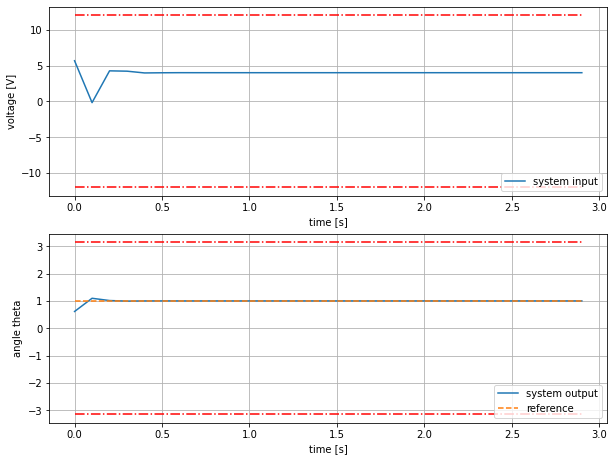

In [217]:
# logs from other scripts
log_q_nmpc = np.load("NonlinearController/experiments/log_q.npy")
log_w_nmpc = np.load("NonlinearController/experiments/log_w.npy")
log_u_lpv = np.load("NonlinearController/experiments/u_log.npy")
log_y_lpv = np.load("NonlinearController/experiments/y_log.npy")

fig1 = plt.figure(figsize=[10, 16])
# fig1 = plt.figure(figsize=[16, 8])

plt.subplot(4,1,1)
plt.plot(np.arange(nr_sim_steps)*dt, log_w[0,:], label='system input')
# plt.plot(np.arange(nr_sim_steps)*dt, np.hstack((log_u_lpv[1:],log_u_lpv[-1])), label='lpv input')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*w_max, 'r-.')#, label='max')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*w_min, 'r-.')#, label='min')
plt.xlabel("time [s]")
plt.ylabel("voltage [V]")
plt.grid()
plt.legend(loc='lower right')


plt.subplot(4,1,2)
# plt.plot(np.arange(nr_sim_steps)*dt, (log_q[0,:]+np.pi)%(2*np.pi) - np.pi, label='system output')
# plt.plot(np.arange(nr_sim_steps)*dt, (reference[0,:nr_sim_steps]+np.pi)%(2*np.pi) - np.pi, '--', label='reference')
plt.plot(np.arange(nr_sim_steps)*dt, log_q[0,:], label='system output')
plt.plot(np.arange(nr_sim_steps)*dt, reference[0,:nr_sim_steps], '--', label='reference')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*np.pi, 'r-.')#, label='max')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*-np.pi, 'r-.')#, label='min')
plt.xlabel("time [s]")
plt.ylabel("angle theta")
plt.grid()
plt.legend(loc='lower right')

# plt.subplot(2,2,3)
# plt.plot(np.arange(nr_sim_steps)*dt, log_e[0,:], label='e')
# plt.xlabel("time [s]")
# plt.ylabel("e")
# plt.grid()
# plt.legend(loc='upper right')

# plt.subplot(2,2,4)
# plt.plot(np.arange(nr_sim_steps)*dt, log_iterations[0,:], label='iQP')
# plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*nr_iterations, 'r-.', label='max iter')
# plt.xlabel("time [s]")
# plt.ylabel("iterations")
# plt.grid()
# plt.legend(loc='upper right')

plt.show()

In [ ]:
np.unique(log_iterations, return_counts=True)

In [ ]:
np.unique(log_iterations, return_counts=True)

In [ ]:
old_theta = log_q[0,:]; old_u = log_w[0,:]

In [ ]:
old_theta_2 = log_q[0,:]; old_u_2 = log_w[0,:]

In [ ]:
fig1 = plt.figure(figsize=[16, 10])

plt.subplot(2,1,1)
plt.plot(np.arange(nr_sim_steps)*dt, log_w[0,:], label='MMVT')
plt.plot(np.arange(nr_sim_steps)*dt, old_u, label='FTC 1 step')
plt.plot(np.arange(nr_sim_steps)*dt, old_u_2, label='FTC 20 steps')
# plt.plot(np.arange(nr_sim_steps)*dt, np.hstack((log_u_lpv[1:],log_u_lpv[-1])), label='lpv input')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*w_max, 'r-.')#, label='max')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*w_min, 'r-.')#, label='min')
plt.xlabel("time [s]")
plt.ylabel("voltage [V]")
plt.grid()
plt.legend(loc='lower right')

plt.subplot(2,1,2)
# plt.plot(np.arange(nr_sim_steps)*dt, (log_q[0,:]+np.pi)%(2*np.pi) - np.pi, label='FTC 20 steps')
# plt.plot(np.arange(nr_sim_steps)*dt, (old_theta+np.pi)%(2*np.pi) - np.pi, label='FTC 1 step')
plt.plot(np.arange(nr_sim_steps)*dt, log_q[0,:], label='MMVT')
plt.plot(np.arange(nr_sim_steps)*dt, old_theta, label='FTC 1 step')
plt.plot(np.arange(nr_sim_steps)*dt, old_theta_2, label='FTC 20 steps')

# plt.plot(np.arange(nr_sim_steps)*dt, old_theta - theta)
plt.plot(np.arange(nr_sim_steps)*dt, (reference_theta[:nr_sim_steps]+np.pi)%(2*np.pi) - np.pi, 'k--', label='reference')
plt.xlabel("time [s]")
plt.ylabel("angle theta")
plt.grid()
plt.legend(loc='lower right')